<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/all_text_concat_ulmfit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

In [47]:
import os
from pathlib import Path
import fastai
fastai.__version__

'2.7.9'

In [48]:
# config depending on whether this is running on kaggle or collab
# is_colab = True
is_colab = not os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
comp = 'feedback-prize-effectiveness'
if is_colab:
    model_save_path = Path('/content/'+comp+'_out/models')
else:
    model_save_path = Path('/kaggle/working/'+comp) #+'/models')

In [49]:
# import colab libraries
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
if is_colab:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [51]:
# This permissions change avoids a warning on Kaggle tool startup.
if is_colab:
    !chmod 600 ~/.kaggle/kaggle.json

In [52]:
path = setup_comp(comp)
path

Path('feedback-prize-effectiveness')

In [53]:
from fastai.text.all import *
set_seed(32)

## Language model for original text

In [54]:
# In this cell fastai TextDataLoader functions are overridden to allow taking output 
# directory as input so that the toknised data is not written in data input directory
# in Kaggle, data input directory is read-only
from fastai.text.core import _tokenize_files
@delegates(_tokenize_files)
def tokenize_folderOP(path, extensions=None, folders=None,
                      output_dir=None, skip_if_exists=True, **kwargs):
    """replacement of fastai.text.core.tokenize_folder so that it passes
     output_dir as input to _tokenize_files"""
    path,extensions = Path(path),ifnone(extensions, ['.txt'])
    files = get_files(path, extensions=extensions, recurse=True, folders=folders)
    def _f(i,output_dir): return output_dir/files[i].relative_to(path)
    return _tokenize_files(_f, files, path, output_dir, 
                           skip_if_exists=skip_if_exists, **kwargs)

class TokenizerOP(Tokenizer):
    """Wrapper class for fastai.text.core.Tokenizer class to override
    from_folder method to take output_dir as input and call the overridden
    method tokenize_folderOP"""
    def __init__(self, tok, rules=None, counter=None,
                 lengths=None, mode=None, sep=' '):
        super().__init__(tok, rules=rules, counter=counter,
                 lengths=lengths, mode=mode, sep=sep)
    
    @classmethod
    @delegates(tokenize_folderOP, keep=True)
    def from_folder(cls, path, tok=None, rules=None, output_dir = None, **kwargs):
        path = Path(path)
        if tok is None: tok = WordTokenizer()
        output_dir = tokenize_folderOP(path, tok=tok, rules=rules, 
                                       skip_if_exists = False, 
                                       output_dir = output_dir, **kwargs)
        res = cls(tok, counter=load_pickle(output_dir/fn_counter_pkl),
                  lengths=load_pickle(output_dir/fn_lengths_pkl),
                  rules=rules, mode='folder')
        res.path,res.output_dir = path,output_dir
        return res


class TextBlockOP(TextBlock):
    "Overriding TextBlock for user defined output dir"
    def __init__(self, tok_tfm, vocab=None, is_lm=False,
                 seq_len=72, backwards=False, **kwargs):
        super().__init__(tok_tfm, vocab=vocab, is_lm=is_lm,
                 seq_len=seq_len, backwards=backwards, **kwargs)
    @classmethod
    @delegates(TokenizerOP.from_folder, keep=True)
    def from_folder(cls, path, vocab=None, is_lm=False, seq_len=72,
                    backwards=False, min_freq=3, max_vocab=60000,output_dir =None,
                    **kwargs):
        "Build a `TextBlock` from a `path` - calls TokenizerOP and provides output_dir as input"
        return cls(TokenizerOP.from_folder(path, output_dir = output_dir, **kwargs), vocab=vocab, is_lm=is_lm, seq_len=seq_len,
                   backwards=backwards, min_freq=min_freq, max_vocab=max_vocab)
        
class TextDataLoadersOP(TextDataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for NLP problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None,
                    seed=None, vocab=None, text_vocab=None, is_lm=False,
                    tok_tfm=None, seq_len=72, splitter=None,
                    backwards=False, output_dir =None, **kwargs):
        "This is to override same method from TextDataLoaders to accept and pass output_dir as input"
        if splitter is None:
            splitter = GrandparentSplitter(train_name=train,
                                           valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct,
                                                                                                      seed=seed)
        blocks = [TextBlockOP.from_folder(path, text_vocab, is_lm, seq_len, backwards,
                                          tok=tok_tfm, output_dir = output_dir)]
        if not is_lm: blocks.append(CategoryBlock(vocab=vocab))
        get_items = partial(get_text_files, folders=[train,valid]) if valid_pct is None else get_text_files
        dblock = DataBlock(blocks=blocks,
                           get_items=get_items,
                           splitter=splitter,
                           get_y=None if is_lm else parent_label)
        return cls.from_dblock(dblock, path, path=path, seq_len=seq_len, **kwargs)


In [55]:
tok_path = model_save_path / 'train_tok'
tok_path.mkdir(parents=True, exist_ok=True)
dls_lm = TextDataLoadersOP.from_folder(path / 'train', is_lm=True,
                                       valid_pct=0.1, output_dir = tok_path)
# TextDataLoaders.from_folder(path / 'train', is_lm=True, valid_pct=0.1, )
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj dear xxmaj principal , \n\n xxmaj community service would be a great thing for every student to be required to do . \n\n xxmaj even though some people may think it is a pretty big time waster , helping the community is doing an act of service , which every student should be able to enjoy . \n\n i believe that doing community service would help the community , make","xxmaj dear xxmaj principal , \n\n xxmaj community service would be a great thing for every student to be required to do . \n\n xxmaj even though some people may think it is a pretty big time waster , helping the community is doing an act of service , which every student should be able to enjoy . \n\n i believe that doing community service would help the community , make students"
1,"technology in order to drive successfully . \n\n xxmaj some pieces of equipment include a video camera , a xxup gps receiver , and multiple sensors . \n\n xxmaj the most important part of the driverless car is the spinning sensor located on the roof . \n\n xxmaj by using laser beams to form a constantly updating 3 - d model , this sensor allows the car to recognize its surroundings .","in order to drive successfully . \n\n xxmaj some pieces of equipment include a video camera , a xxup gps receiver , and multiple sensors . \n\n xxmaj the most important part of the driverless car is the spinning sensor located on the roof . \n\n xxmaj by using laser beams to form a constantly updating 3 - d model , this sensor allows the car to recognize its surroundings . \n\n"
2,"we love to help another community . \n\n xxmaj we need to help other community , we do n't care if they going to help us or not . xxmaj if we help them first then they know who help them . xxmaj next time they going help us back too . xxmaj we have to help them first . xxmaj in xxmaj united states , they do n't need for help","love to help another community . \n\n xxmaj we need to help other community , we do n't care if they going to help us or not . xxmaj if we help them first then they know who help them . xxmaj next time they going help us back too . xxmaj we have to help them first . xxmaj in xxmaj united states , they do n't need for help ."
3,in trouble may many of times . xxmaj one year i was playing softball xxunk up the xxunk arm for the game i did n't have any gear on not even a face mask to protect my face well my phone xxunk in my pocket and i was so exited to see what it was . xxmaj so i looked at the text well the xxunk did n't know that at the,trouble may many of times . xxmaj one year i was playing softball xxunk up the xxunk arm for the game i did n't have any gear on not even a face mask to protect my face well my phone xxunk in my pocket and i was so exited to see what it was . xxmaj so i looked at the text well the xxunk did n't know that at the time
4,up with that idea . xxmaj another reason why i think this is a cool idea is because it knows who you are even when you have on different face expression . xxmaj that 's amazing how a computer can express how we feel .i ' m so xxunk that a computer can do that . i some time ask myself how do they do that . \n\n i think that computers,with that idea . xxmaj another reason why i think this is a cool idea is because it knows who you are even when you have on different face expression . xxmaj that 's amazing how a computer can express how we feel .i ' m so xxunk that a computer can do that . i some time ask myself how do they do that . \n\n i think that computers would


In [56]:
# dump vocab that will be required for inference script
with open(model_save_path / 'dls_lm_vocab.pickle', 'wb') as b:
    pickle.dump(dls_lm.vocab,b)

In [57]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [58]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.761091,3.471994,0.318496,32.200886,01:32


In [59]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.534671,3.366488,0.333500,28.976568,01:40
1,3.389978,3.261568,0.351238,26.090405,01:39
2,3.274298,3.186084,0.362552,24.193501,01:39
3,3.154108,3.139869,0.368952,23.100840,01:40
4,3.068381,3.111421,0.373271,22.452919,01:40
5,2.964190,3.092495,0.377843,22.031973,01:40
6,2.930666,3.076802,0.379852,21.688921,01:39
7,2.870389,3.068114,0.381112,21.501318,01:39
8,2.805694,3.067487,0.381916,21.487841,01:40
9,2.801700,3.069555,0.381724,21.532314,01:39


In [60]:
model_save_path.mkdir(parents=True, exist_ok=True)
if iskaggle:
    # hack to save encoder in a writable location
    learn_lm.path = model_save_path
    learn_lm.save_encoder('finetuned_enc')
    # learn_lm.save('finetuned_lm')
else:
    learn_lm.save_encoder(model_save_path / 'finetuned_enc')

## Text classification

In [61]:
def file_read(file_path):
    with open(file_path, 'r') as _f: 
        all_content = _f.read()
    return all_content

In [62]:
# pre-process text - add all columns 
df = pd.read_csv(path/'train.csv')
df['essay_text'] = df['essay_id'].apply(lambda x: file_read(path / 'train' / f'{x}.txt'))
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture

In [63]:
# decide sequence length
df['seq_length_essay'] = [len(txt.split()) for txt in df['essay_text'].tolist()]
df['seq_length_dis'] = [len(txt.split()) for txt in df['discourse_text'].tolist()]
df['seq_length_essay'].describe(), df['seq_length_dis'].describe()

(count    36765.000000
 mean       458.588522
 std        220.423420
 min        144.000000
 25%        288.000000
 50%        408.000000
 75%        579.000000
 max       1367.000000
 Name: seq_length_essay, dtype: float64, count    36765.000000
 mean        44.654073
 std         46.669682
 min          1.000000
 25%         16.000000
 50%         28.000000
 75%         57.000000
 max        836.000000
 Name: seq_length_dis, dtype: float64)

In [64]:
# replace discorse text within the context text as __MASKED__
df['masked_ess_txt'] = df[['essay_text','discourse_text']].apply(lambda row: row.essay_text.strip().replace(row.discourse_text.strip(),
                                                                                                         '__MASKED__'),
                                                              axis = 1)
df['seq_length_mask_ess'] = [len(txt.split()) for txt in df['masked_ess_txt'].tolist()]
df['masked_ess_txt'].head(), df['seq_length_mask_ess'].describe()

(0    __MASKED__ On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It's not easy to target Cydonia," in which he is saying that its not easy to know if it is...
 1    Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. __MASKED__\n\nI think that the face is a natural landform because there

In [65]:
# function to truncate discourse text and context text
def trunc_text(text, num_words):
    w_l = text.split()
    if len(w_l) > num_words: w_l = w_l[:num_words]
    return ' '.join(w_l)


In [66]:
# combine all text columns for classification 
# concat all
# df['all_text'] = 'CONTEXT: ' + df.essay_text + '; DISCOURSE: ' + df.discourse_text + '; TYPE: ' + df.discourse_type

# concat after truncation
df['essay_text_trunc'] = df.masked_ess_txt.apply(lambda t: trunc_text(t,512))
df['discourse_text_trunc'] = df.discourse_text.apply(lambda t: trunc_text(t,64))
df['all_text'] = 'CONTEXT: ' + df.essay_text_trunc + '; TYPE: ' + df.discourse_type + '; DISCOURSE: ' + df.discourse_text_trunc 
df['seq_length_all'] = [len(txt.split()) for txt in df['all_text'].tolist()]
df['seq_length_all'].describe()

count    36765.000000
mean       400.149327
std        130.698353
min         69.000000
25%        288.000000
50%        405.000000
75%        528.000000
max        581.000000
Name: seq_length_all, dtype: float64

In [67]:
# create data loaders
dls = TextDataLoaders.from_df(df, text_col='all_text',
                              label_col='discourse_effectiveness',
                              seq_len=650,
                              text_vocab=dls_lm.vocab)
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxup context : xxmaj what xxmaj would xxmaj our xxmaj country xxmaj yet xxmaj the xxmaj world xxmaj be xxmaj like xxmaj with xxmaj driverless xxmaj cars ? xxmaj having xxmaj driverless xxmaj cars xxmaj would xxmaj have xxmaj both xxmaj positive xxmaj and xxmaj negative xxmaj aspects . xxmaj driverless xxmaj cars xxmaj would xxmaj be xxmaj positive xxmaj aspects xxmaj due xxmaj to xxmaj the xxmaj fact xxmaj that xxmaj they xxmaj use xxmaj half xxmaj the xxmaj feul xxmaj of xxmaj today 's xxmaj taxis , xxmaj they xxmaj offer xxmaj far xxmaj more xxmaj flexibility xxmaj than a xxmaj bus xxmaj would , xxmaj and xxmaj many xxmaj other xxmaj aspects . xxmaj driverless xxmaj cars xxmaj would xxmaj have xxmaj negative xxmaj aspects xxmaj do xxmaj to xxmaj the xxmaj fact xxmaj that xxmaj the xxmaj driverless xxmaj cars xxmaj can xxmaj not xxmaj",Adequate
1,"xxbos xxup context : _ _ xxunk _ _ . xxmaj driverless xxmaj cars xxmaj would xxmaj be xxmaj positive xxmaj aspects xxmaj due xxmaj to xxmaj the xxmaj fact xxmaj that xxmaj they xxmaj use xxmaj half xxmaj the xxmaj feul xxmaj of xxmaj today 's xxmaj taxis , xxmaj they xxmaj offer xxmaj far xxmaj more xxmaj flexibility xxmaj than a xxmaj bus xxmaj would , xxmaj and xxmaj many xxmaj other xxmaj aspects . xxmaj driverless xxmaj cars xxmaj would xxmaj have xxmaj negative xxmaj aspects xxmaj do xxmaj to xxmaj the xxmaj fact xxmaj that xxmaj the xxmaj driverless xxmaj cars xxmaj can xxmaj not xxmaj navigate xxmaj work xxmaj zones xxmaj or xxmaj go xxmaj around xxmaj accidents xxmaj without a xxmaj driver . xxmaj my xxmaj first xxmaj reason , xxmaj that xxmaj they xxmaj use xxmaj half xxmaj the xxmaj feul xxmaj of",Ineffective
2,"xxbos xxup context : _ _ xxunk advantages of limiting car usage is people are happier without cars and it promotes the alternative transportation and reduce smog . xxmaj the first advantage of limiting car usage is that people are happier without cars . "" the day without cars is part of an improvement campaign that began in xxmaj bogota in the mid-1990s . xxmaj it has seen the construction of 118 miles of bicycle paths , the most of any xxmaj latin xxmaj american city , according to xxmaj mockus , the city 's mayor "" ( selsky , xxmaj paragraph 27 ) . "" as a result , 70 pecent of xxmaj vauban 's families do not own cars , and 57 percent sold a car to move here . "" when i had a car i was always tense . xxmaj i 'm much happier this way",Effective


In [71]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1Score(average='weighted')]).to_fp16()
# load encoder from language model
if iskaggle: model_save_path = model_save_path / 'models'
learn = learn.load_encoder(model_save_path / 'finetuned_enc')

SuggestedLRs(valley=0.001737800776027143, slide=0.03981071710586548)

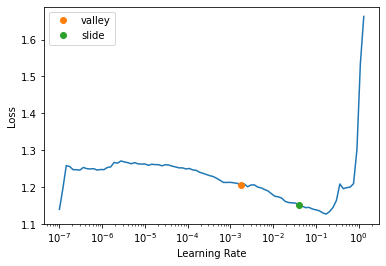

In [72]:
learn.lr_find(suggest_funcs=(valley, slide))

In [73]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.882575,0.776346,0.648443,0.614563,02:36


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.797463,0.703136,0.685979,0.659614,05:57
1,0.750121,0.687300,0.688971,0.679484,05:57
2,0.659880,0.655780,0.716442,0.690461,05:56
3,0.565237,0.641485,0.726914,0.705648,05:57
4,0.497921,0.657648,0.719978,0.710813,05:56


In [74]:
model_save_path.mkdir(parents=True, exist_ok=True)
# learn.export(f'{model_save_path}/all_col_concat_learner.pkl')
learn.save(f'{model_save_path}/all_text_concat_ulmfit_save.pkl')

Path('/content/feedback-prize-effectiveness_out/models/all_text_concat_ulmfit_save.pkl.pth')

## Test submission

In [75]:
test_df = pd.read_csv(path/'test.csv')
# pre-process test df texts
test_df['essay_text'] = test_df['essay_id'].apply(lambda x: file_read(path / 'test' / f'{x}.txt'))
test_df['masked_ess_txt'] = test_df[['essay_text','discourse_text']].apply(lambda row: row.essay_text.strip().replace(row.discourse_text.strip(),
                                                                                                         '__MASKED__'),
                                                              axis = 1)
test_df['essay_text_trunc'] = test_df.masked_ess_txt.apply(lambda t: trunc_text(t,512))
test_df['discourse_text_trunc'] = test_df.discourse_text.apply(lambda t: trunc_text(t,64))
test_df['text'] = 'CONTEXT: ' + test_df.essay_text_trunc + '; TYPE: ' + test_df.discourse_type + '; DISCOURSE: ' + test_df.discourse_text_trunc 

In [76]:
# test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   discourse_id          10 non-null     object
 1   essay_id              10 non-null     object
 2   discourse_text        10 non-null     object
 3   discourse_type        10 non-null     object
 4   essay_text            10 non-null     object
 5   masked_ess_txt        10 non-null     object
 6   essay_text_trunc      10 non-null     object
 7   discourse_text_trunc  10 non-null     object
 8   text                  10 non-null     object
dtypes: object(9)
memory usage: 848.0+ bytes


In [77]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxup context : xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself . xxmaj seeking multiple opinions can help a person make a better choice because it can decrease stress levels , a great chance to learn something new , can be very helpful and beneficial . xxmaj to begin with , xxmaj seeking information from more than one person can decrease stress levels . xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj"
1,"xxbos xxup context : _ _ xxunk _ _ xxmaj seeking multiple opinions can help a person make a better choice because it can decrease stress levels , a great chance to learn something new , can be very helpful and beneficial . xxmaj to begin with , xxmaj seeking information from more than one person can decrease stress levels . xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice . xxmaj when you ask other"
2,"xxbos xxup context : xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself . _ _ xxunk _ _ because it can decrease stress levels , a great chance to learn something new , can be very helpful and beneficial . xxmaj to begin with , xxmaj seeking information from more than one person can decrease stress levels . xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make"
3,"xxbos xxup context : xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself . xxmaj seeking multiple opinions can help a person make a better choice because _ _ xxunk _ _ , a great chance to learn something new , can be very helpful and beneficial . xxmaj to begin with , xxmaj seeking information from more than one person can decrease stress levels . xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj"
4,"xxbos xxup context : xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself . xxmaj seeking multiple opinions can help a person make a better choice because it can decrease stress levels , _ _ xxunk _ _ , can be very helpful and beneficial . xxmaj to begin with , xxmaj seeking information from more than one person can decrease stress levels . xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple"
5,"xxbos xx

In [78]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[0.5380, 0.4526, 0.0094],
        [0.9464, 0.0498, 0.0038],
        [0.1419, 0.8516, 0.0065],
        [0.0711, 0.9026, 0.0263],
        [0.1712, 0.8105, 0.0183],
        [0.0404, 0.9423, 0.0173],
        [0.0019, 0.9900, 0.0081],
        [0.2101, 0.7824, 0.0075],
        [0.4934, 0.4977, 0.0089],
        [0.1440, 0.8490, 0.0070]])

In [79]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = dls.vocab[1])
probs_df

,Adequate,Effective,Ineffective
0,0.538024,0.452619,0.009357
1,0.946432,0.049775,0.003793
2,0.141907,0.851641,0.006452
3,0.071077,0.902584,0.026340
4,0.171223,0.810500,0.018277
5,0.040423,0.942301,0.017276
6,0.001867,0.989992,0.008141
7,0.210075,0.782432,0.007493
8,0.493365,0.497721,0.008914
9,0.144040,0.848965,0.006995


In [80]:
probs_df["discourse_id"] = test_df["discourse_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

Adequate,Effective,Ineffective,discourse_id
0.53802365,0.4526191,0.009357187,a261b6e14276
0.9464322,0.049774803,0.0037930408,5a88900e7dc1
0.14190716,0.8516411,0.006451758,9790d835736b
0.07107655,0.90258366,0.026339816,75ce6d68b67b
0.17122254,0.8105002,0.018277291,93578d946723
0.040423013,0.9423013,0.017275712,2e214524dbe3
0.0018668629,0.9899921,0.008141022,84812fc2ab9f
0.21007515,0.78243184,0.0074930005,c668ff840720
0.4933655,0.49772084,0.008913602,739a6d00f44a


In [81]:
# not working for this competetion
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial', comp)

In [82]:
if not iskaggle:
    push_notebook('saan', comp,
                  title='Feedback effeciveness with essay text using ulmfit',
                  file='/content/drive/MyDrive/Colab Notebooks/all_text_concat_ulmfit_model.ipynb',
                  competition=comp, private=False, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/saansd2003/feedback-effeciveness-with-essay-text-using-ulmfit
